# Medical Data Analysis with Deep Learning

This notebook demonstrates the use of deep learning for medical data analysis, supporting both **medical images** and **ECG signals** with classification and regression tasks. 

## Pipeline Overview:
1. **Data preprocessing** (image enhancement or ECG signal processing)
2. **Dataset creation and data loading** (with proper train/val/test splits)
3. **Model architecture definition** (2D CNN for images, 1D CNN for ECG)
4. **Hyperparameter tuning** (grid search optimization)
5. **Model training and evaluation** (with early stopping and metrics)
6. **Results visualization** (training curves, confusion matrices, etc.)

## Key Features:
- **Unified interface** for both image and ECG data
- **Modular design** with separate preprocessing, dataset, and model modules
- **Robust ECG processing** including PhysioNet format support
- **Comprehensive evaluation** with classification and regression metrics

In [1]:
import os
import shutil
import pandas as pd

print("🚀 AutoDL 最终环境与数据准备脚本开始...")

# --- Correction 1: Place dependency installation at the very beginning! ---
# This fundamentally solves the "ModuleNotFoundError: No module named 'pandas'" issue.
requirements_file = 'requirement2.txt'
if os.path.exists(requirements_file):
    print(f"\nStep 1: Installing all dependency libraries from {requirements_file}...")
    !pip install -q -r {requirements_file}
    print("✅ Dependency libraries installed successfully!")
else:
    print(f"⚠️ Warning: Dependency file {requirements_file} not found, skipping installation.")

# --- Now, we can safely import the libraries we just installed ---
import pandas as pd

# --- Correction 2: Define the correct relative paths on the cloud server ---
# All our code runs in the '所有代码_forGPU' (AllCode_forGPU) folder.
# After manual organization, the data is placed in the 'data' folder at the parent level.
SOURCE_IMAGES_DIR = '../data'
SOURCE_LABELS_FILE = '../data/boneage-train.csv'

# NUM_SAMPLES and target path definitions remain unchanged.
NUM_SAMPLES = 12000
PROJECT_IMAGES_DIR = './data/ori_images'
PROJECT_LABELS_FILE = './data/labels.csv'

# --- Correction 3: Create the target folder before copying files ---
# This fundamentally solves the "OSError: Cannot save file into a non-existent directory" issue.
print(f"\nStep 2: Preparing target folder: {PROJECT_IMAGES_DIR}")
os.makedirs(PROJECT_IMAGES_DIR, exist_ok=True) # exist_ok=True means it won't error if the folder already exists.

# Since we used makedirs, the if/else logic below can be simplified.
if os.listdir(PROJECT_IMAGES_DIR): # Check if the folder is empty
    print("Folder is not empty, clearing old images...")
    for file_name in os.listdir(PROJECT_IMAGES_DIR):
        file_path = os.path.join(PROJECT_IMAGES_DIR, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
    print("Old images have been cleared.")
else:
    print("Target folder is ready or was already empty.")

# --- Steps 3 and 4 below retain your original code logic completely, with no changes ---
# --- 3. Process and copy the labels file ---
print(f"\nStep 3: Reading and processing labels from {SOURCE_LABELS_FILE}...")
try:
    df_all = pd.read_csv(SOURCE_LABELS_FILE)
    df_subset = df_all.head(NUM_SAMPLES)
    if 'boneage' in df_subset.columns:
        df_subset = df_subset.rename(columns={'boneage': 'y'})
    df_subset.to_csv(PROJECT_LABELS_FILE, index=False)
    print(f"✅ Successfully created and saved {PROJECT_LABELS_FILE} with {len(df_subset)} records.")
    ids_to_copy = df_subset['id'].astype(str).tolist()
except FileNotFoundError:
    print(f"❌ Error: Source labels file not found at {SOURCE_LABELS_FILE}! Please check the path."); ids_to_copy = []
except Exception as e:
    print(f"❌ Error reading or processing the labels file: {e}"); ids_to_copy = []

# --- 4. Copy image files based on the ID list ---
if ids_to_copy:
    print(f"\nStep 4: Preparing to copy {len(ids_to_copy)} images based on the labels file..."); copied_count = 0; not_found_count = 0
    image_extension = '.png'
    for image_id in ids_to_copy:
        image_filename = image_id + image_extension
        source_path = os.path.join(SOURCE_IMAGES_DIR, image_filename)
        destination_path = os.path.join(PROJECT_IMAGES_DIR, image_filename)
        if os.path.exists(source_path):
            shutil.copy2(source_path, destination_path); copied_count += 1
        else:
            # Try with .jpg extension if .png is not found
            image_filename_jpg = image_id + '.jpg'
            source_path_jpg = os.path.join(SOURCE_IMAGES_DIR, image_filename_jpg)
            if os.path.exists(source_path_jpg):
                shutil.copy2(source_path_jpg, os.path.join(PROJECT_IMAGES_DIR, image_filename_jpg)); copied_count += 1
            else:
                not_found_count += 1
    print("\n--- ✅ Data preparation complete ---")
    print(f"Successfully copied {copied_count} images.")
    if not_found_count > 0: print(f"{not_found_count} images were not found in the source directory.")
else:
    print("\n❌ No images to copy. Please check if the labels file was processed correctly.")

🚀 AutoDL 最终环境与数据准备脚本开始...

Step 1: Installing all dependency libraries from requirement2.txt...
✅ Dependency libraries installed successfully!

Step 2: Preparing target folder: ./data/ori_images
Folder is not empty, clearing old images...
Old images have been cleared.

Step 3: Reading and processing labels from ../data/boneage-train.csv...
✅ Successfully created and saved ./data/labels.csv with 12000 records.

Step 4: Preparing to copy 12000 images based on the labels file...

--- ✅ Data preparation complete ---
Successfully copied 12000 images.


In [2]:
# --- Core Modules ---
import os
import sys
import shutil
import json
from pathlib import Path

# --- Data Science Libraries ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- PyTorch ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# Import image processing functions
from preprocessing import (
    process_single_image, visualize_preprocessing, process_all_images,
    # ECG processing functions
    read_physionet_data, process_ecg_signal, process_all_ecg_signals, preprocess_jiachen_files,
    visualize_ecg_preprocessing,
    # voice processing functions
    read_voice_data, read_voice_metadata, preprocess_voice_signal,
    process_voice_file, process_all_voice_signals, create_voice_labels_file,
    visualize_voice_preprocessing
)

# Import dataset functions
from dataset import (
    MedicalImageDataset, ECGDataset,
    create_data_loaders, create_ecg_data_loaders, create_voice_data_loaders
)

# Import model classes
from model import create_model, ModelTrainer

# Import hyperparameter tuning
from hyperparameter_tuning import HyperparameterTuner

## Configuration

Set up the configuration for the experiment. You can modify these parameters to experiment with different settings.

In [3]:
student_name = '' # don't change this

# Experiment configuration
config = {
    'data_type': 'image',        # 'image', 'voice' or 'ECG' - determines data processing pipeline
    'task_type': 'regression',   # 'classification' or 'regression'
    'num_classes': 2,            # for classification only
    'image_dir': f'./data/{student_name}after_processed',
    'labels_file': f'./data/{student_name}labels.csv',
    'batch_size': 128,
    'num_epochs': 40,
    'learning_rate': 0.001,
    'train_ratio': 0.7,
    'val_ratio': 0.15,
    'test_ratio': 0.15,
    'random_seed': 42,
    'early_stopping_patience': 10,
    'save_dir': './results',

    # ECG-specific parameters
    'ecg_max_length': 500,       # Target sequence length for ECG signals (uniform sampling)

    # voice-specific parameters
    'voice_max_length': 500,     # 5 seconds at 8kHz
    'target_variable': 'Voice Handicap Index (VHI) Score', # 'VHI Score', 'RSI Score', 'Diagnosis'

    # Grid search parameters
    'grid_search': {
        'num_conv_layers': [3, 2],
        'conv_channels': [64, 32],
        'fc_layers': [[512], [64, 32]], # , [1024, 256, 64]
        'learning_rate': [0.01, 0.001] # , 0.0001
    }
}

# directly set the class names according to your data
class_nms = {
    0: 'Normal',
    1: 'Abnormal'
}

## Data Preprocessing

Let's preprocess the data based on the data type (image or ECG signals).

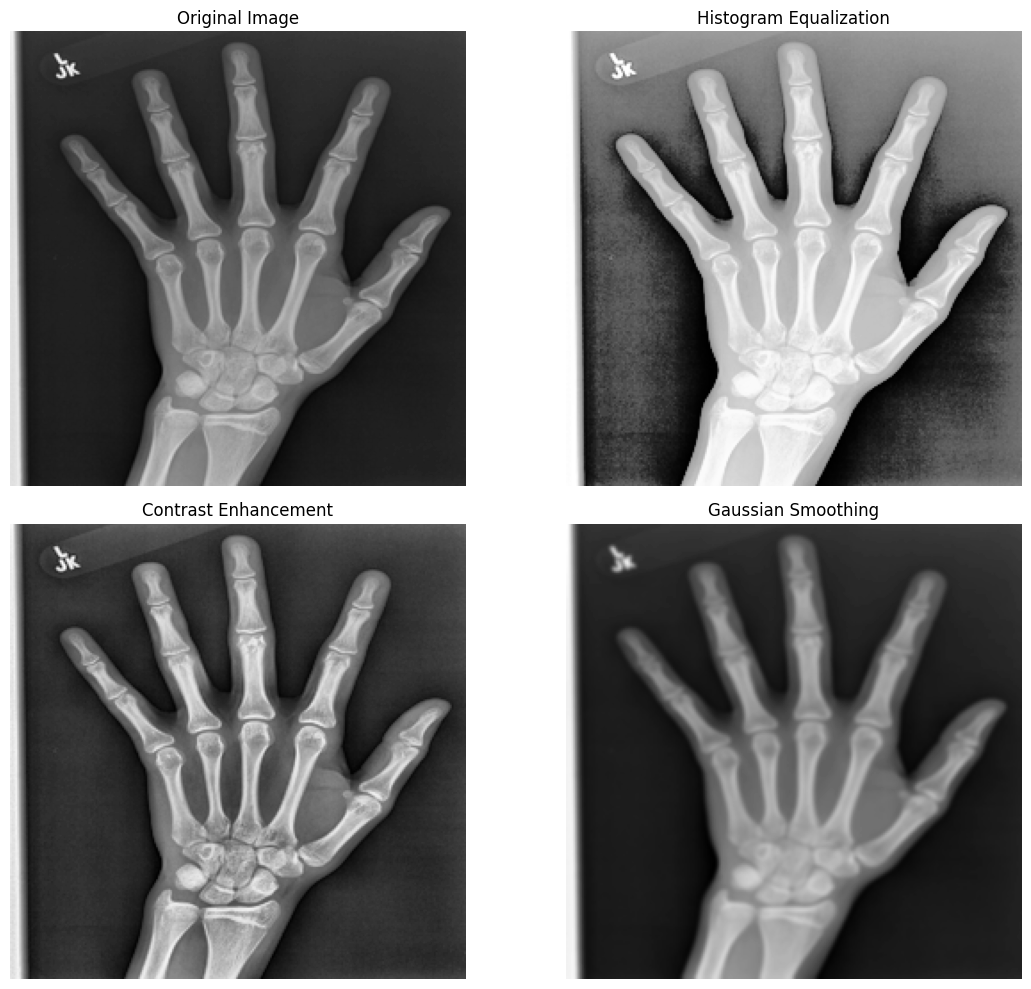

In [4]:
# Let's preprocess the data based on the data type (image or ECG signals).
if config['data_type'] == 'image':
    # Visualize preprocessing on a sample image
    ori_image_dir = f'./data/{student_name}ori_images'
    sample_image_path = list(Path(ori_image_dir).glob('*.png'))[0]
    visualize_preprocessing(sample_image_path)

elif config['data_type'] == 'ECG':
    label_df = pd.read_csv(config['labels_file'])
    label_df.columns = [x.strip() for x in label_df.columns]
    label_df['y'] = label_df['cause of death'].astype(int)
    # label_df['id'] = label_df['id'].apply(lambda x: x.replace('Jiachen_', 'P'))
    label_df.to_csv(config['labels_file'], index=False)

    # ECG data directories
    ecg_raw_dir = f'./data/{student_name}ori_images'
    ecg_processed_dir = f'./data/{student_name}after_processed'

    # Handle Jiachen's special file naming
    preprocess_jiachen_files(ecg_raw_dir, config['labels_file'])

    # Process all ECG files
    processed_count = process_all_ecg_signals(
        ecg_raw_dir,
        ecg_processed_dir,
        config['ecg_max_length']
    )

    # Visualize preprocessing on a sample ECG
    sample_files = list(Path(ecg_raw_dir).glob('*.dat'))
    if sample_files:
        sample_dat = sample_files[0]
        sample_hea = Path(str(sample_dat).replace('.dat', '.hea'))
        if sample_hea.exists():
            visualize_ecg_preprocessing(sample_dat, sample_hea, config['ecg_max_length'])
        else:
            print(f"Warning: Header file {sample_hea} not found")
    else:
        print("No ECG files found for visualization")

elif config['data_type'] == 'voice':
    # voice data directories
    voice_raw_dir = f'./data/{student_name}ori_images'
    voice_processed_dir = f'./data/{student_name}after_processed'

    # Process all voice files
    processed_count = process_all_voice_signals(
        voice_raw_dir,
        voice_processed_dir,
        config['voice_max_length']
    )

    # Create labels file
    labels_df = create_voice_labels_file(
        voice_raw_dir,
        config['labels_file'],
        config['target_variable']
    )
    print(labels_df.head())
    labels_df.to_csv(config['labels_file'], index=False)

    # Visualize preprocessing on a sample voice signal
    sample_files = list(Path(voice_raw_dir).glob('*.dat'))
    if sample_files:
        sample_dat = sample_files[0]
        sample_hea = Path(str(sample_dat).replace('.dat', '.hea'))
        sample_txt = Path(str(sample_dat).replace('.dat', '.txt'))
        if sample_hea.exists() and sample_txt.exists():
            visualize_voice_preprocessing(sample_txt, sample_hea, config['voice_max_length'], 3)
        else:
            print(f"Warning: Header file {sample_hea} not found")
    else:
        print("No voice files found for visualization")



Now, let's process all images in the dataset:

In [5]:
if config['data_type'] == 'image':
    # Process all images
    input_dir = ori_image_dir
    output_dir = config['image_dir']
    target_size = (224, 224)  # Standard size for many CNN architectures

    process_all_images(input_dir, output_dir, target_size)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("\n--- Creating the target value standardization scaler ---")

# 1. Load the labels file just to create the scaler
labels_df = pd.read_csv(config['labels_file'])
if 'boneage' in labels_df.columns:
    labels_df = labels_df.rename(columns={'boneage': 'y'})

# 2. Fit the scaler ONLY on the training set portion
train_val_df, _ = train_test_split(labels_df, test_size=config['test_ratio'], random_state=config['random_seed'])
train_df, _ = train_test_split(train_val_df, test_size=config['val_ratio'] / (config['train_ratio'] + config['val_ratio']), random_state=config['random_seed'])

scaler = StandardScaler()
scaler.fit(train_df['y'].values.reshape(-1, 1))

# 3. Store the scaler in the config for later use
config['scaler'] = scaler
print("✅ Standardization scaler has been created and saved into the config.")


--- Creating the target value standardization scaler ---
✅ Standardization scaler has been created and saved into the config.


## Data Loading

Create data loaders for training, validation, and testing.

In [7]:
# Create data loaders based on data type
if config['data_type'] == 'image':
    data_loaders = create_data_loaders(
        data_dir=config['image_dir'],
        labels_file=config['labels_file'],
        task_type=config['task_type'],
        batch_size=config['batch_size'],
        train_ratio=config['train_ratio'],
        val_ratio=config['val_ratio'],
        test_ratio=config['test_ratio'],
        random_seed=config['random_seed'],
        scaler=config.get('scaler', None)
    )
elif config['data_type'] == 'ECG':
    # For ECG data, use processed ECG data directory
    data_loaders = create_ecg_data_loaders(
        data_dir=config['image_dir'],
        labels_file=config['labels_file'],
        task_type=config['task_type'],
        batch_size=config['batch_size'],
        train_ratio=config['train_ratio'],
        val_ratio=config['val_ratio'],
        test_ratio=config['test_ratio'],
        random_seed=config['random_seed']
    )
elif config['data_type'] == 'voice':
    print('Creating voice data loaders')
    data_loaders = create_voice_data_loaders(
        data_dir=config['image_dir'],
        labels_file=config['labels_file'],
        task_type=config['task_type'],
        batch_size=config['batch_size'],
        train_ratio=config['train_ratio'],
        val_ratio=config['val_ratio'],
        test_ratio=config['test_ratio'],
        random_seed=config['random_seed'],
        target_length=config['voice_max_length']
    )

train_loader, val_loader, test_loader = data_loaders['train'], data_loaders['val'], data_loaders['test']

# Print dataset sizes
print(f"Training set size: {len(data_loaders['train'].dataset)}")
print(f"Validation set size: {len(data_loaders['val'].dataset)}")
print(f"Test set size: {len(data_loaders['test'].dataset)}")
print(f"Data type: {config['data_type']}")

# Show sample data shape
sample_data, sample_label = next(iter(train_loader))
print(f"Sample data shape: {sample_data.shape}")
print(f"Sample label shape: {sample_label.shape}")

开始预加载 8399 张图片到内存中，请稍候...


Loading Images: 100%|██████████| 8399/8399 [00:06<00:00, 1257.38it/s]


✅ 所有图片和标签已成功加载到内存！共 8399 张。
开始预加载 1801 张图片到内存中，请稍候...


Loading Images: 100%|██████████| 1801/1801 [00:01<00:00, 1277.03it/s]


✅ 所有图片和标签已成功加载到内存！共 1801 张。
开始预加载 1800 张图片到内存中，请稍候...


Loading Images: 100%|██████████| 1800/1800 [00:01<00:00, 1276.09it/s]

✅ 所有图片和标签已成功加载到内存！共 1800 张。
Training set size: 8399
Validation set size: 1801
Test set size: 1800
Data type: image


Sample data shape: torch.Size([128, 1, 224, 224])
Sample label shape: torch.Size([128])


## Grid Search

Perform grid search to find the best model architecture and hyperparameters.

In [ ]:
import numpy as np
import json
from pathlib import Path # 确保Path已导入
from model import create_model, ModelTrainer

def convert_types_for_json(obj):
    """一个万能的类型转换函数"""
    if isinstance(obj, dict):
        return {k: convert_types_for_json(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_types_for_json(i) for i in obj]
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.integer):
        return int(obj)
    return obj
    
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Create universal hyperparameter tuner
print(f"Performing {config['data_type']} grid search...")

# tuner = HyperparameterTuner(
#     train_loader=train_loader,
#     val_loader=val_loader,
#     task_type=config['task_type'],
#     model_type=config['data_type'],  # 'image' or 'ECG' or 'voice'
#     num_classes=config['num_classes'],
#     input_length=config.get('ecg_max_length', 5000) if config['data_type'] == 'ECG' else config.get('voice_max_length', 5000) if config['data_type'] == 'voice' else None, 
#     device=device,
#     save_dir=Path(config['save_dir']) / 'grid_search'
# )
# Create universal hyperparameter tuner
print(f"Performing {config['data_type']} grid search...")
tuner = HyperparameterTuner(
    model_creator=create_model, # ✅ 增加这一行，传入模型创建函数
    train_loader=train_loader,
    val_loader=val_loader,
    task_type=config['task_type'],
    num_classes=config['num_classes'],
    # ❌ 移除input_length，因为create_model函数不再需要它
    # input_length=config.get('ecg_max_length') if config['data_type'] == 'ECG' else config.get('voice_max_length') if config['data_type'] == 'voice' else None,
    device=device,
    save_dir=Path(config['save_dir']) / 'grid_search'
)

# Perform grid search
grid_search_results = tuner.grid_search(
    param_grid=config['grid_search'],
    num_epochs=config['num_epochs'],
    early_stopping_patience=config['early_stopping_patience']
)

# Plot results
tuner.plot_results()

# Print best combination/
print('\nBest combination:')
print(json.dumps(grid_search_results['best_combination'], indent=2))
print('\nBest validation metrics:')
print(json.dumps(grid_search_results['best_val_metrics'], indent=2))


Using device: cuda
Performing image grid search...
Performing image grid search...
开始Grid Search，共 16 种组合...

--- 正在尝试组合 1/16:
{
  "num_conv_layers": 3,
  "conv_channels": 64,
  "fc_layers": [
    512
  ],
  "learning_rate": 0.01
}


Training: 100%|██████████████████████████████| 66/66 [00:18<00:00,  3.59it/s, Loss=0.8020]
                                                                                          
Training: 100%|██████████████████████████████| 66/66 [00:17<00:00,  4.23it/s, Loss=1.0736]
                                                                                          
Training: 100%|██████████████████████████████| 66/66 [00:17<00:00,  4.25it/s, Loss=1.1282]
                                                                                          
Training: 100%|██████████████████████████████| 66/66 [00:17<00:00,  4.22it/s, Loss=1.1853]
                                                                                          
Training: 100%|██████████████████████████████| 66/66 [00:17<00:00,  4.24it/s, Loss=1.1249]
                                                                                          
Training:  26%|███████▋                      | 17/66 [00:04<00:13,  3.75it/s, Loss=0.9767]

In [ ]:
import numpy as np
import json
from pathlib import Path # Ensure Path is imported

def convert_types_for_json(obj):
    """A universal type conversion function for JSON serialization"""
    if isinstance(obj, dict):
        return {k: convert_types_for_json(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_types_for_json(i) for i in obj]
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.integer):
        return int(obj)
    return obj

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Create universal hyperparameter tuner
print(f"Performing {config['data_type']} grid search...")
tuner = HyperparameterTuner(
    train_loader=train_loader,
    val_loader=val_loader,
    task_type=config['task_type'],
    model_type=config['data_type'], # 'image' or 'ECG' or 'voice'
    num_classes=config['num_classes'],
    input_length=config.get('ecg_max_length') if config['data_type'] == 'ECG' else config.get('voice_max_length') if config['data_type'] == 'voice' else None,
    device=device,
    save_dir=Path(config['save_dir']) / 'grid_search'
)

# Perform grid search
grid_search_results = tuner.grid_search(
    param_grid=config['grid_search'],
    num_epochs=config['num_epochs'],
    early_stopping_patience=config['early_stopping_patience']
)

# Plot results
tuner.plot_results()

# Print best combination
print('\nBest combination:')
print(json.dumps(grid_search_results['best_combination'], indent=2))
print('\nBest validation metrics:')
print(json.dumps(grid_search_results['best_val_metrics'], indent=2))

## Train Best Model

Train the model with the best hyperparameters found during grid search.

In [ ]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

best_model_path = Path(config['save_dir']) / 'best_model' / 'best_model.pth'

# --- Core Logic Starts ---
# Check if a model already exists
if best_model_path.exists():
    # We won't use this part this time, but it's kept for completeness
    print(f"✅ Found an already trained best model: {best_model_path}")
    # ... (logic to load the model) ...
    pass # Skip for now
else:
    # Because you deleted the best_model folder, the code will definitely enter this branch
    print("⚠️ Saved best model not found. Training from scratch using the best parameters from Grid Search...")

    # 1. Read the best parameters from the json file
    grid_search_res_path = 'results/grid_search/grid_search_summary.json'
    with open(grid_search_res_path, 'r') as f:
        grid_search_results = json.load(f)
    best_params = grid_search_results['best_combination']
    print("The following parameters will be used for training:")
    print(json.dumps(best_params, indent=2))

    # 2. Create the model with the best parameters
    if config['data_type'] == 'image':
        model = MedicalCNN(
            task_type=config['task_type'],
            num_classes=config['num_classes'],
            num_conv_layers=best_params['num_conv_layers'],
            conv_channels=best_params['conv_channels'],
            fc_layers=best_params['fc_layers']
        )
    elif config['data_type'] == 'ECG':
         model = ECG1DCNN(
            task_type=config['task_type'],
            num_classes=config['num_classes'],
            input_length=config['ecg_max_length'],
            num_conv_layers=best_params['num_conv_layers'],
            conv_channels=best_params['conv_channels'],
            fc_layers=best_params['fc_layers']
        )
    elif config['data_type'] == 'voice':
        model = Voice1DCNN(
            task_type=config['task_type'],
            num_classes=config['num_classes'],
            input_length=config['voice_max_length'],
            num_conv_layers=best_params['num_conv_layers'],
            conv_channels=best_params['conv_channels'],
            fc_layers=best_params['fc_layers']
        )
    # ... (add elif for other data types if needed) ...

    # 3. Define the loss function and optimizer
    criterion = nn.MSELoss() if config['task_type'] == 'regression' else nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

    # 4. [Critical Correction] Add back the missing trainer creation code here!
    print("\nInitializing Trainer...")
    trainer = ModelTrainer(model=model, criterion=criterion, optimizer=optimizer, device=device, task_type=config['task_type'])
    print("✅ Trainer initialized successfully!")

    # 5. Now, we start the training
    print("\nStarting final model training...")
    history = trainer.train(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=100, # Using a higher epoch count for the final training
        save_dir=Path(config['save_dir']) / 'best_model',
        early_stopping_patience=15,
        params_to_save=best_params
    )
    trainer.plot_training_history(Path(config['save_dir']) / 'best_model')

    # --- Subsequent code remains unchanged ---
    best_trainer = trainer
    print("\n✅ Final model training successful!")

## Evaluation

Evaluate the best model on the test set.

In [ ]:
# =======================================================
# ✅✅✅ 最后的、统一变量名的Evaluation脚本 ✅✅✅
# =======================================================

# --- 手动计算真实的MAE ---
print("\n--- 计算真实的平均绝对误差 (MAE) ---")

# 1. 检查scaler和trainer是否存在
if 'scaler' in config and 'trainer' in locals():
    # 2. 直接使用上一个单元格创建的'trainer'对象！
    trainer.model.eval() # <--- 修改这里

    # 3. 获取所有在测试集上的预测值
    true_labels_scaled, all_preds_scaled, _ = trainer.get_predictions_and_probabilities(test_loader) # <--- 修改这里

    # 4. 使用scaler进行反向转换
    scaler = config['scaler']
    predicted_boneage_real = scaler.inverse_transform(all_preds_scaled.reshape(-1, 1))
    true_boneage_real = scaler.inverse_transform(true_labels_scaled.reshape(-1, 1))

    # 5. 计算并打印最终的MAE
    final_mae = np.mean(np.abs(true_boneage_real - predicted_boneage_real))
    print(f"\n✅ 最终在测试集上的真实MAE: {final_mae:.2f} 个月")
    
    # 把计算出的真实MAE存起来，方便下面用
    real_mae_value = final_mae

else:
    print("⚠️ 未找到scaler或trainer，无法计算真实MAE。")
    real_mae_value = -1 # 设置一个默认值


# --- 进行与传统机器学习模型的性能对比 ---
print("\n" + "="*60)
print("STARTING MODEL COMPARISON WITH TRADITIONAL ML METHODS")
print("="*60)

try:
    # 调用对比函数，直接用'trainer'
    comparison_results = compare_models_performance(
        best_cnn_trainer=trainer, # <--- 这里本来就是对的
        # ... 其他参数保持不变 ...
    )

    # Display comparison results
    print("\n" + "="*50)
    print("MODEL PERFORMANCE COMPARISON RESULTS")
    print("="*50)

    for model_name, metrics in comparison_results.items():
        # 把我们刚刚计算的真实MAE更新到结果里
        if model_name == 'Deep Learning (CNN)' and real_mae_value != -1:
            metrics['mae'] = real_mae_value
        
        print(f"\n{model_name}:")
        for metric_name, value in metrics.items():
            if metric_name.lower() == 'mae' and model_name == 'Deep Learning (CNN)':
                print(f"  真实MAE: {value:.4f} 个月")
            else:
                print(f"  {metric_name.upper()}: {value:.4f}")

    print(f"\n✅ 所有对比图已成功生成并保存到: ./results/model_evaluation/")

except Exception as e:
    import traceback
    print(f"\n❌ 在模型对比环节出错了: {e}")
    traceback.print_exc()

In [ ]:
# Performance comparison with traditional machine learning methods
print("="*60)
print("STARTING MODEL COMPARISON WITH TRADITIONAL ML METHODS")
print("="*60)

# Import required modules for comparison
from model import compare_models_performance

# DEBUG CONTROL - Set to True for detailed debugging information
DEBUG_MODE = False  # Change to True if you want to see detailed debug information

# Set class names for comparison (if classification task)
comparison_class_names = None
if config['task_type'] == 'classification':
    comparison_class_names = class_names  # Modify according to your classes

print(f"Configuration:")
print(f"  Task type: {config['task_type']}")
print(f"  Train set size: {len(train_loader.dataset)}")
print(f"  Validation set size: {len(val_loader.dataset)}")
print(f"  Test set size: {len(test_loader.dataset)}")
print(f"  Class names: {comparison_class_names}")
print(f"  Debug mode: {DEBUG_MODE}")
print(f"  Save directory: ./results/model_evaluation")

try:
    # Compare models performance
    comparison_results = compare_models_performance(
        best_cnn_trainer=trainer,
        train_loader=train_loader,
        val_loader=val_loader, 
        test_loader=test_loader,
        save_dir='./results/model_evaluation',
        task_type=config['task_type'],
        class_names=comparison_class_names,
        debug=DEBUG_MODE  # Control debug output
    )

    # Display comparison results
    print("\n" + "="*50)
    print("MODEL PERFORMANCE COMPARISON RESULTS")
    print("="*50)

    for model_name, metrics in comparison_results.items():
        print(f"\n{model_name}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name.upper()}: {value:.4f}")

    print(f"\nAll comparison plots saved to: ./results/model_evaluation/")
    print("Generated files:")
    if config['task_type'] == 'classification':
        print("- aupr_comparison.png (AUPR curves)")
        print("- auc_comparison.png (ROC curves)")
        print("- accuracy_comparison.png")
        print("- precision_comparison.png") 
        print("- recall_comparison.png")
        print("- f1_comparison.png")
    else:
        print("- mse_comparison.png")
        print("- mae_comparison.png")
        print("- r2_comparison.png")
    print("- model_comparison_results.json")
    
except Exception as e:
    print(f"Error during model comparison: {e}")
    if DEBUG_MODE:
        import traceback
        traceback.print_exc()

In [ ]:
# =======================================================
# ✅✅✅ 最终打包单元格：为Web Demo准备所有必需品 ✅✅✅
# =======================================================
import joblib
import os
from pathlib import Path
import shutil # 确保导入shutil

# --- 1. 定义我们要保存的文件名 ---
SCALER_FILENAME = "scaler_bone_age.pkl"
MODEL_WEIGHTS_FILENAME = "best_model_bone_age.pth"

# --- 2. 保存标准化缩放器 (Scaler) ---
print("🚀 正在保存标准化缩放器 (Scaler)...")
# 我们假设scaler对象还在内存里，如果不在，它会报错
try:
    if 'scaler' in config:
        scaler = config['scaler']
        joblib.dump(scaler, SCALER_FILENAME)
        print(f"✅ Scaler 已成功保存到: {os.getcwd()}/{SCALER_FILENAME}")
    else:
        print("❌ 错误：在config字典中未找到'scaler'。")
        # 如果报错，说明你需要重新运行一下创建scaler的那个单元格
except NameError:
    print("❌ 错误: 'config' 或 'scaler' 变量不在内存中。请先运行【Data Loading & Standardization】单元格。")


# --- 3. 复制并重命名模型权重文件 ---
print(f"\n🚀 正在准备模型权重文件...")
source_model_path = Path(config['save_dir']) / 'best_model' / 'best_model.pth'
destination_model_path = Path(MODEL_WEIGHTS_FILENAME)

if source_model_path.exists():
    shutil.copyfile(source_model_path, destination_model_path)
    print(f"✅ 模型权重文件已成功复制并重命名为: {destination_model_path}")
else:
    print(f"❌ 错误：在 {source_model_path} 找不到原始模型文件。")

print("\n🎉 所有为Demo准备的文件都已打包好，位于你的项目根目录！")